## Different Optimisers for SPMe Parameter Estimation

In this notebook, we demonstrate parameter estimation for a single-particle model for various PyBOP optimisers. PyBOP offers a variety of gradient and non-gradient based optimisers, with the current support methods show in this table. In this example, we will setup the model, problem, and cost function and investigate how the different optimisers perform under this task.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [1]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [2]:
import numpy as np

import pybop

### Generate Synthetic Data

To demonstrate the parameter estimation, we first need some data. We will generate synthetic data using a PyBOP DFN forward model, which requires defining a parameter set and the model itself.

#### Defining Parameters and Model

We start by creating an example parameter set, constructing the DFN for synthetic generation, and the model we will be estimating parameter for (SPMe).

In [3]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
synth_model = pybop.lithium_ion.DFN(parameter_set=parameter_set)
model = pybop.lithium_ion.SPMe(parameter_set=parameter_set)

### Simulating the Forward Model

We can then simulate the model using the `predict` method, with a default constant current discharge to generate the voltage data.

In [4]:
t_eval = np.arange(0, 900, 2)
values = synth_model.predict(t_eval=t_eval)

### Adding Noise to Voltage Data

To make the parameter estimation more realistic, we add Gaussian noise to the data.

In [5]:
sigma = 0.002
corrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(t_eval))

## Identify the Parameters

We will now set up the parameter estimation process by defining the datasets for optimisation and selecting the model parameters we wish to estimate.

### Creating Optimisation Dataset

The dataset for optimisation is composed of time, current, and the noisy voltage data:

In [6]:
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

### Defining Parameters to Estimate

We select the parameters for estimation and set up their prior distributions and bounds. In this example, non-geometric parameters for each electrode's active material volume fraction are selected.

In [7]:
parameters = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.6, 0.02),
        bounds=[0.5, 0.8],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.48, 0.02),
        bounds=[0.4, 0.7],
    ),
]

### Select the optimisers to investigate

Now, we can select the optimisers to investigate. The first four (CMAES — NelderMead) are stochastic in nature and don't require gradient information. The next two are gradient based (Adam, GradientDescent, IRPropMin), and the remaining two have gradient and non-gradient based methods.

In [8]:
optimisers = [
    pybop.CMAES,
    pybop.SNES,
    pybop.PSO,
    pybop.XNES,
    pybop.NelderMead,
    pybop.Adam,
    pybop.GradientDescent,
    pybop.IRPropMin,
    pybop.SciPyMinimize,
    pybop.SciPyDifferentialEvolution,
]

### Setting up the Optimisation Problem

With the datasets, parameters, and optimisers defined, we can set up the optimisation problem and cost function. In this example we loop through all of the above optimisers and store the results for later visualisation and analysis.

In [9]:
optims = []
xs = []
problem = pybop.FittingProblem(model, parameters, dataset)
cost = pybop.SumSquaredError(problem)
for optimiser in optimisers:
    print(f"Running {optimiser.__name__}")
    optim = pybop.Optimisation(cost, optimiser=optimiser)
    optim.set_max_unchanged_iterations(40)
    optim.set_max_iterations(100)
    x, _ = optim.run()
    optims.append(optim)
    xs.append(x)

Running CMAES
Running SNES
Running PSO
Running XNES
Running Adam
NOTE: Boundaries ignored by Adam
Running GradientDescent
NOTE: Boundaries ignored by Gradient Descent
Running IRPropMin
Running SciPyMinimize
Running SciPyDifferentialEvolution
Ignoring x0. Initial conditions are not used for differential_evolution.


Next, we can compare the identified parameters across the optimisers. This gives us insight into how well each optimiser traversed the cost landscape. The ground-truth parameter values for the `Chen2020` parameter set are: 

- Positive active material volume fraction: `0.665`
- Negative active material volume fraction: `0.75`

In [10]:
for optim in optims:
    if isinstance(
        optim.optimiser, (pybop.SciPyMinimize, pybop.SciPyDifferentialEvolution)
    ):
        print(f"| Optimiser: {optim.optimiser.name()} | Results: {optim.result.x} |")
    else:
        print(
            f"| Optimiser: {optim.optimiser.name()} | Results: {optim.optimiser.x_best()} |"
        )

| Optimiser: Covariance Matrix Adaptation Evolution Strategy (CMA-ES) | Results: [0.8        0.66516966] |
| Optimiser: Seperable Natural Evolution Strategy (SNES) | Results: [0.79999406 0.66513685] |
| Optimiser: Particle Swarm Optimisation (PSO) | Results: [0.79999388 0.66517631] |
| Optimiser: Exponential Natural Evolution Strategy (xNES) | Results: [0.799999   0.66516625] |
| Optimiser: Adam | Results: [0.79527166 0.66600176] |
| Optimiser: Gradient descent | Results: [30.8396837   0.66423561] |
| Optimiser: iRprop- | Results: [0.8        0.66516786] |
| Optimiser: SciPyMinimize | Results: [0.63597003 0.7       ] |
| Optimiser: SciPyDifferentialEvolution | Results: [0.79999963 0.66516994] |


Many of the above optimisers found the correct value for the Positive active material volume fraction. However, none of them found the correct value for the corresponding negative electrode. Next, we can investigate if this was an optimiser or parameter observability failure.

## Plotting and Visualisation

PyBOP provides various plotting utilities to visualise the results of the optimisation.

### Comparing optimal solution for each optimiser

We can quickly plot the system's response using the estimated parameters for each optimiser and the target dataset.

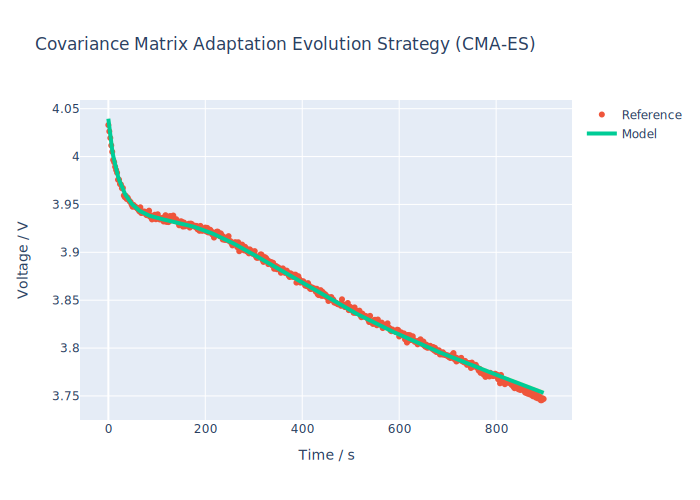

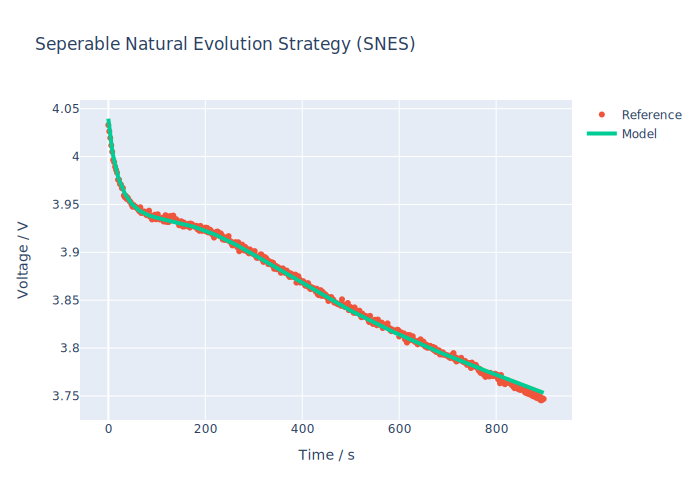

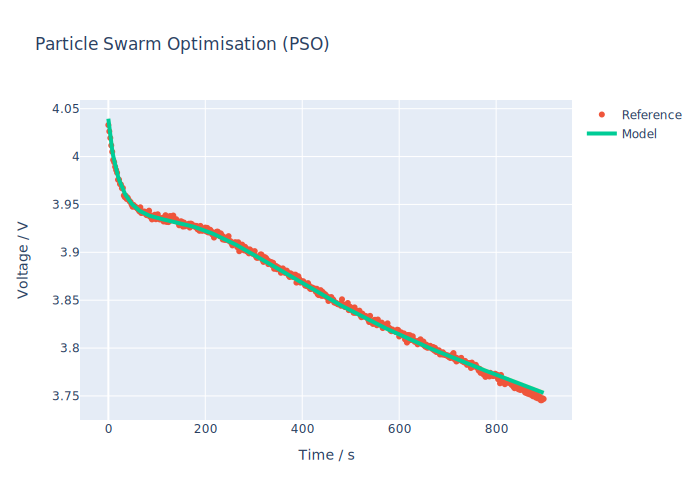

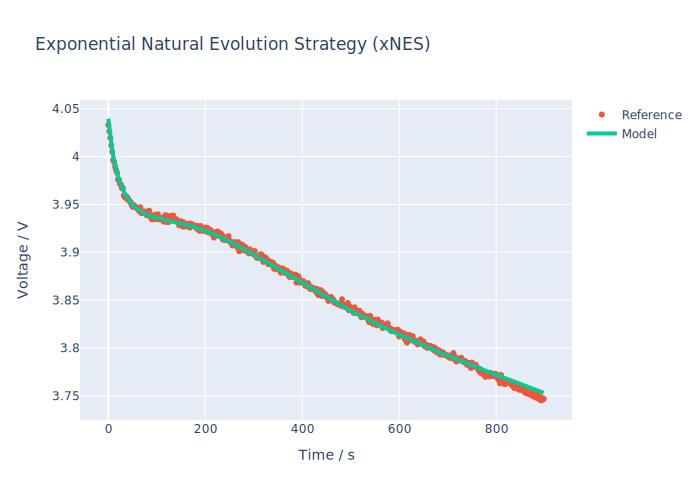

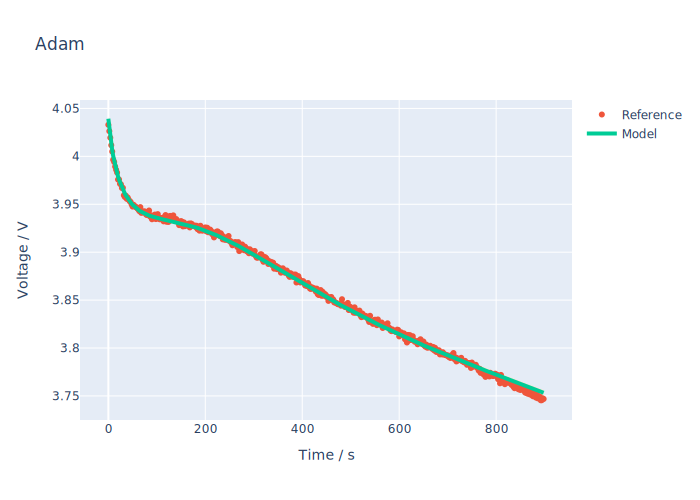

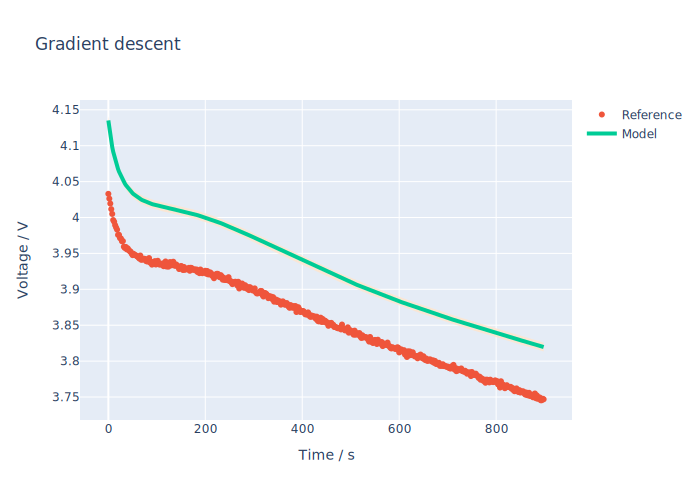

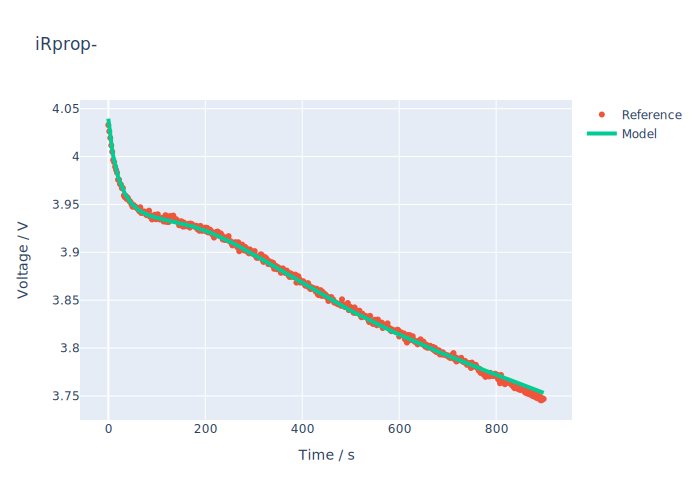

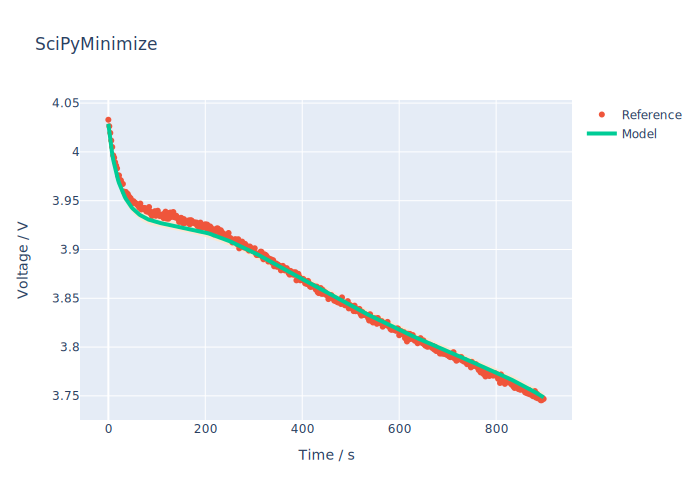

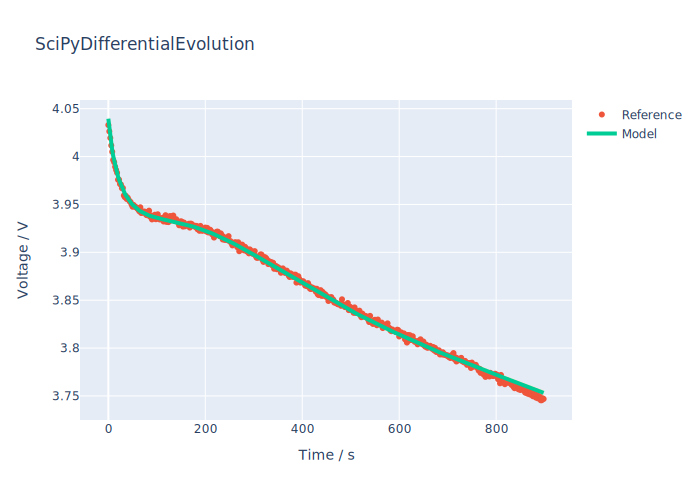

In [11]:
for optim, x in zip(optims, xs):
    pybop.quick_plot(
        optim.cost.problem, parameter_values=x, title=optim.optimiser.name()
    )

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

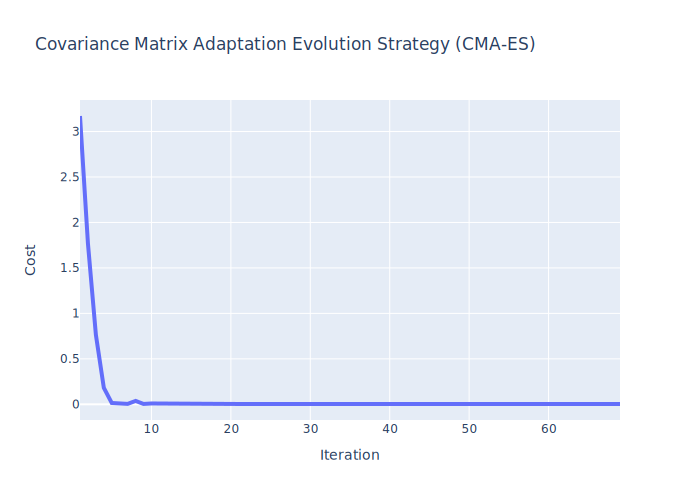

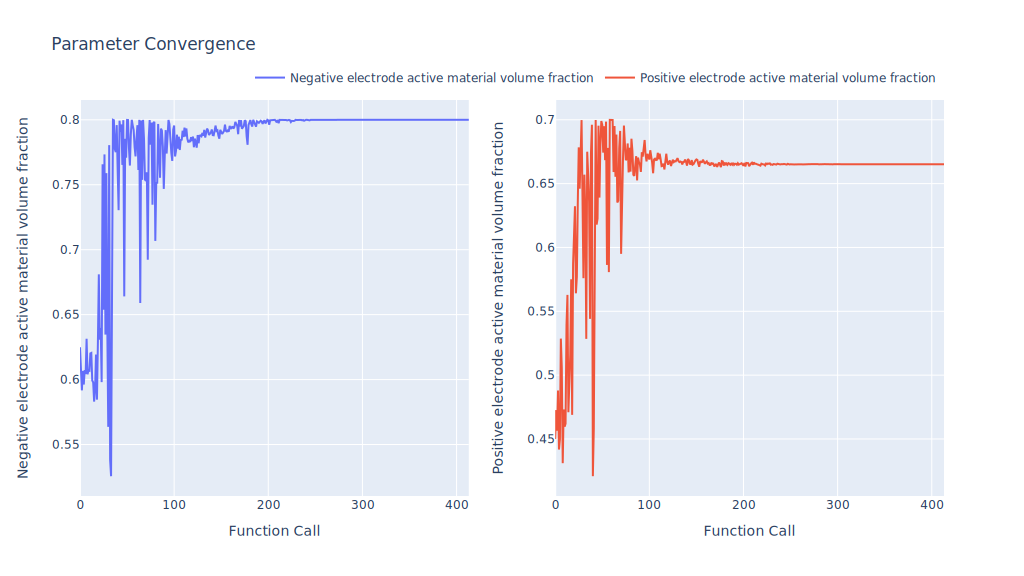

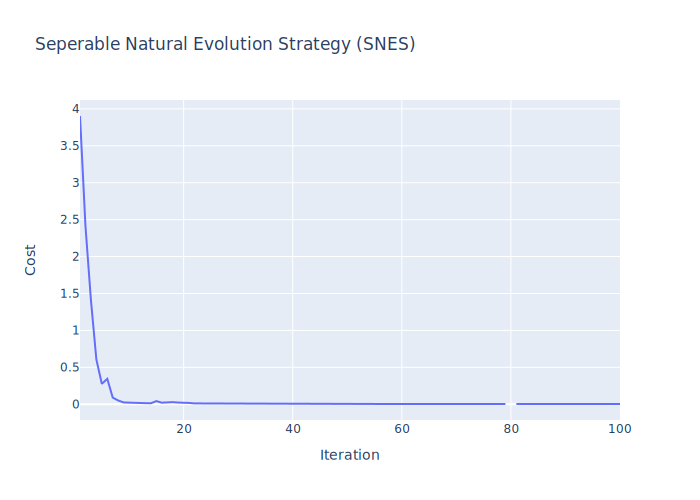

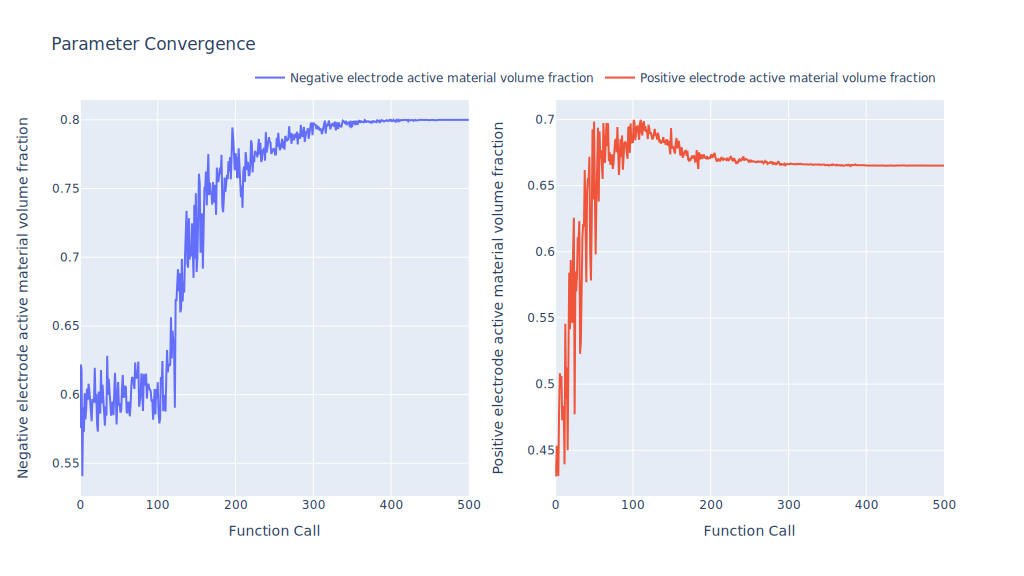

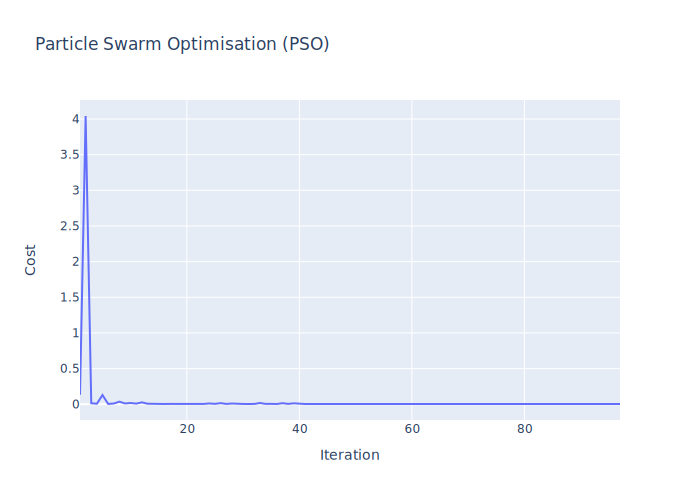

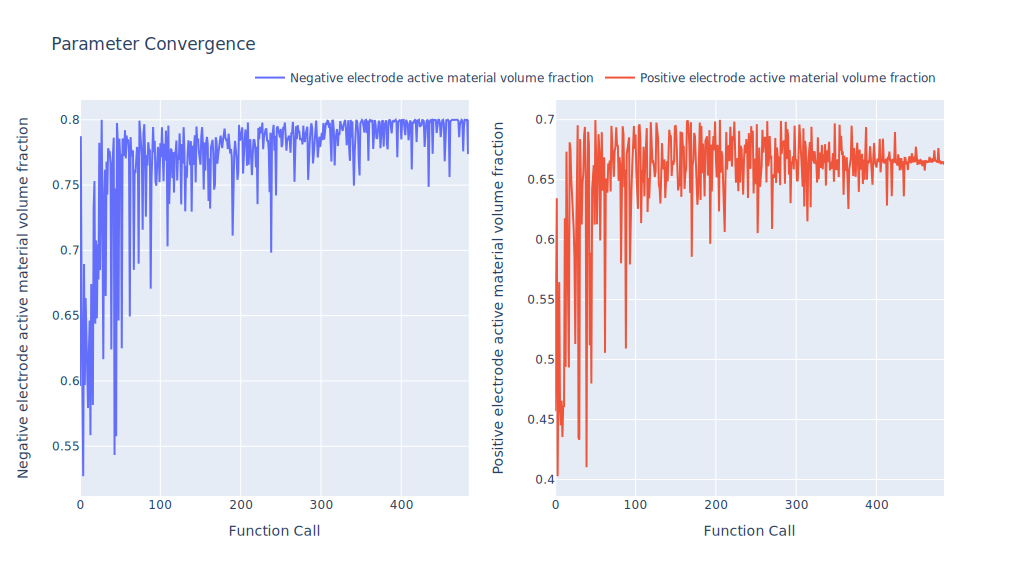

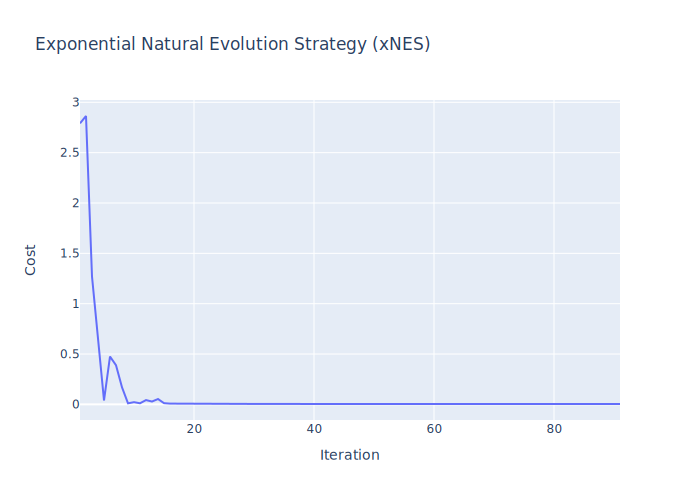

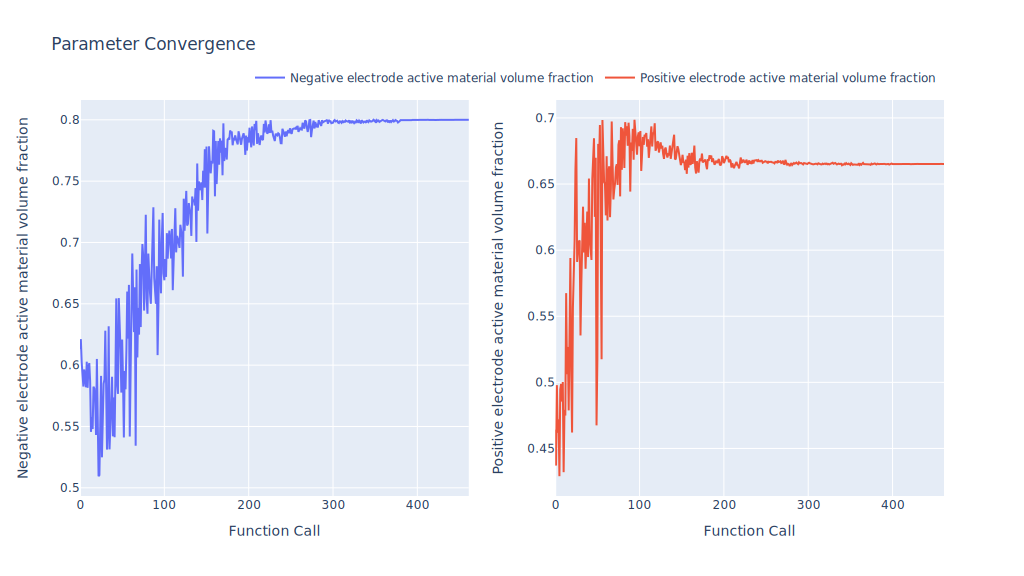

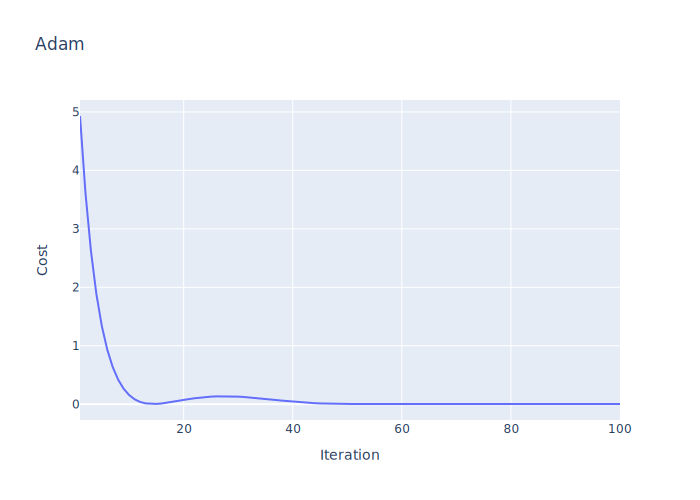

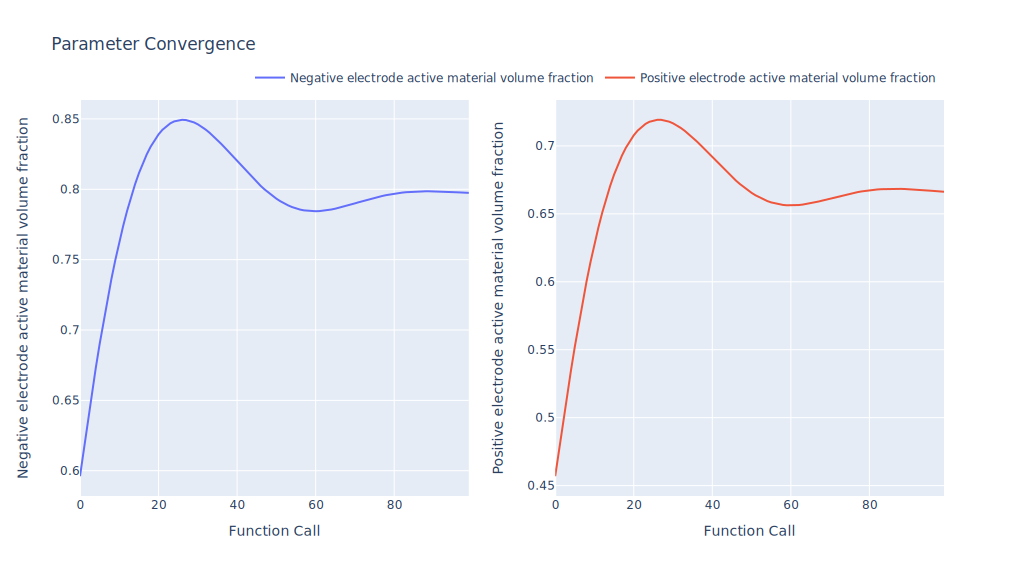

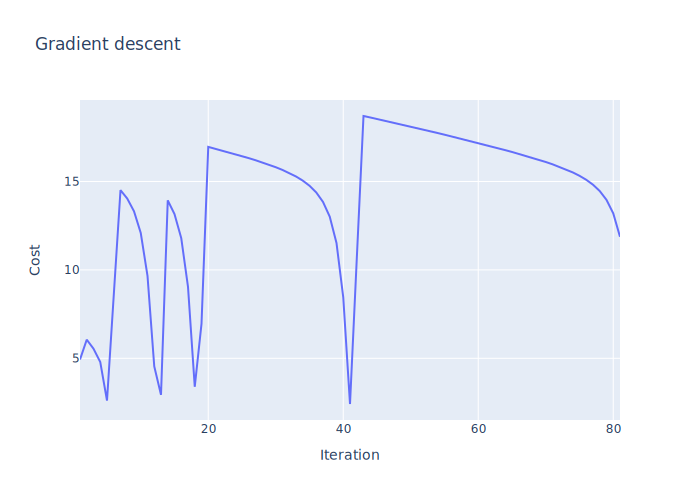

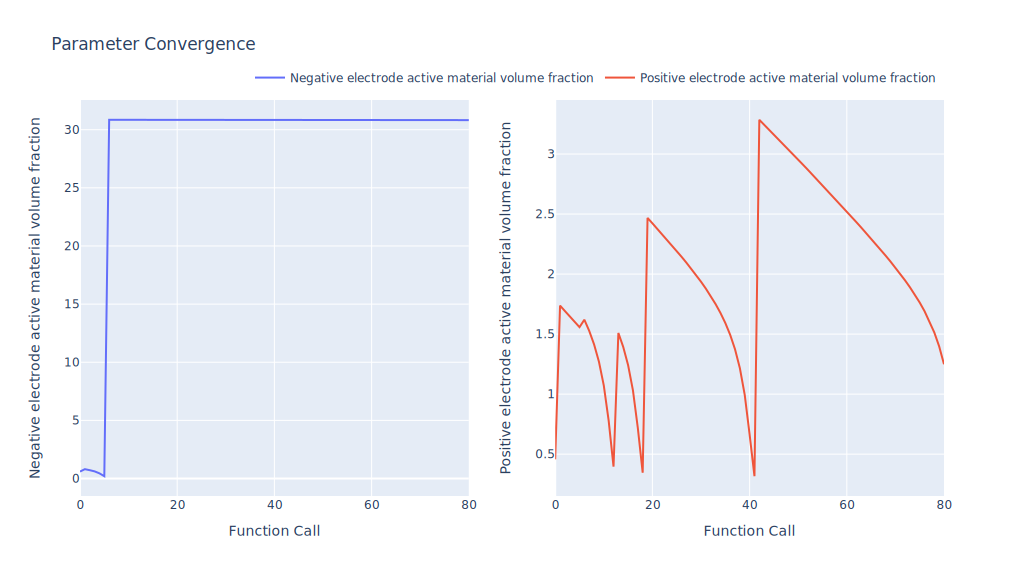

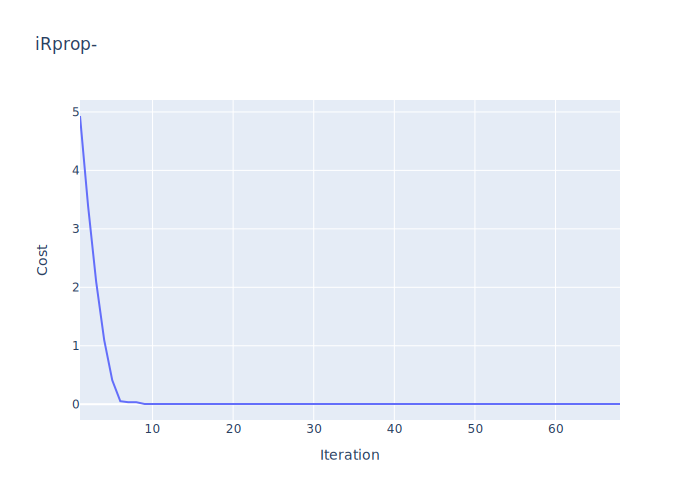

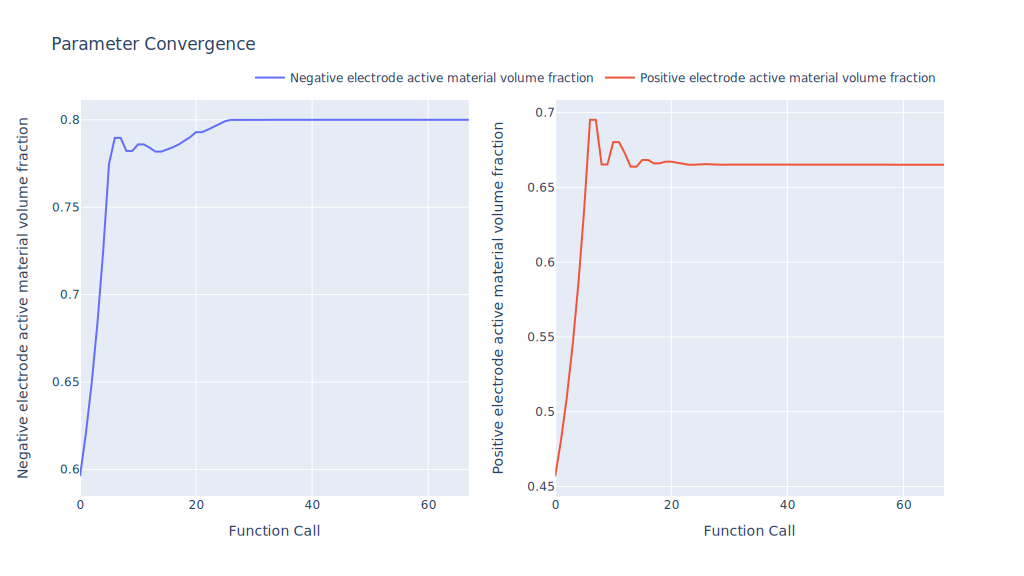

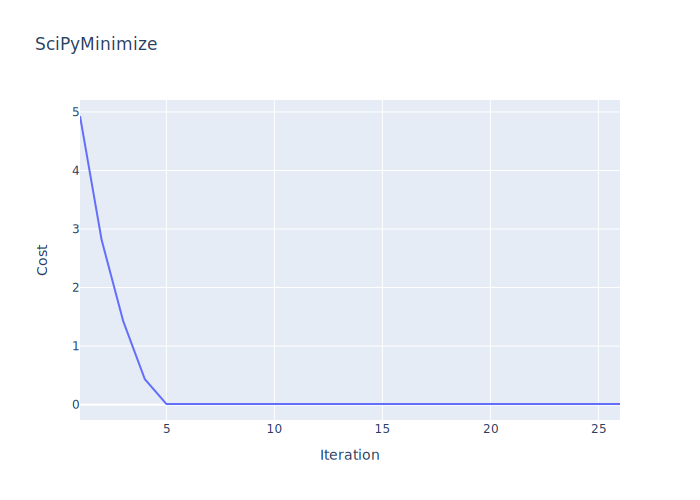

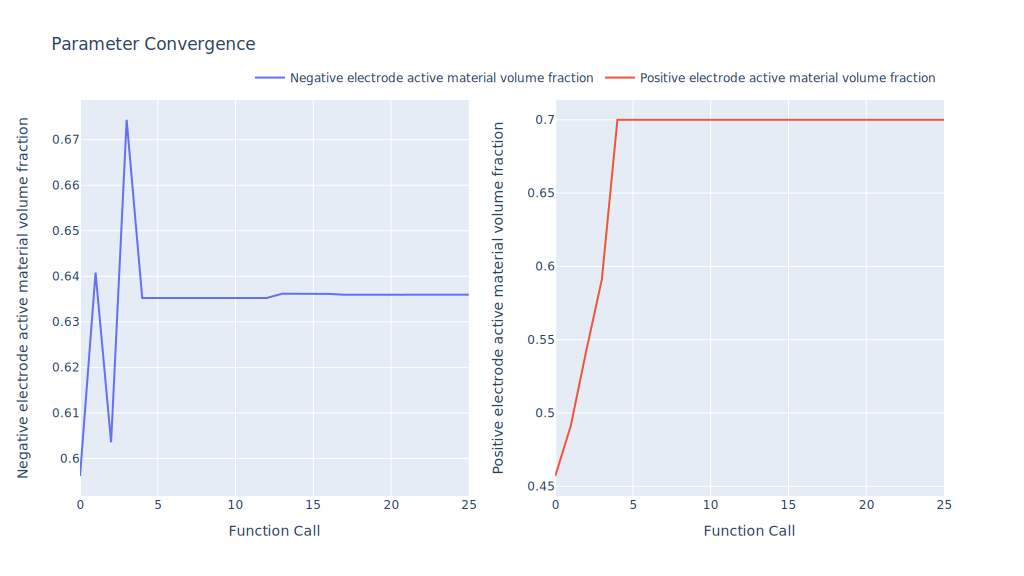

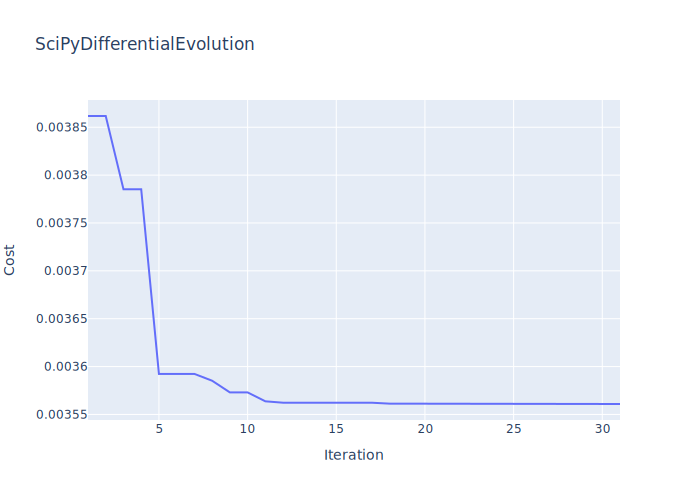

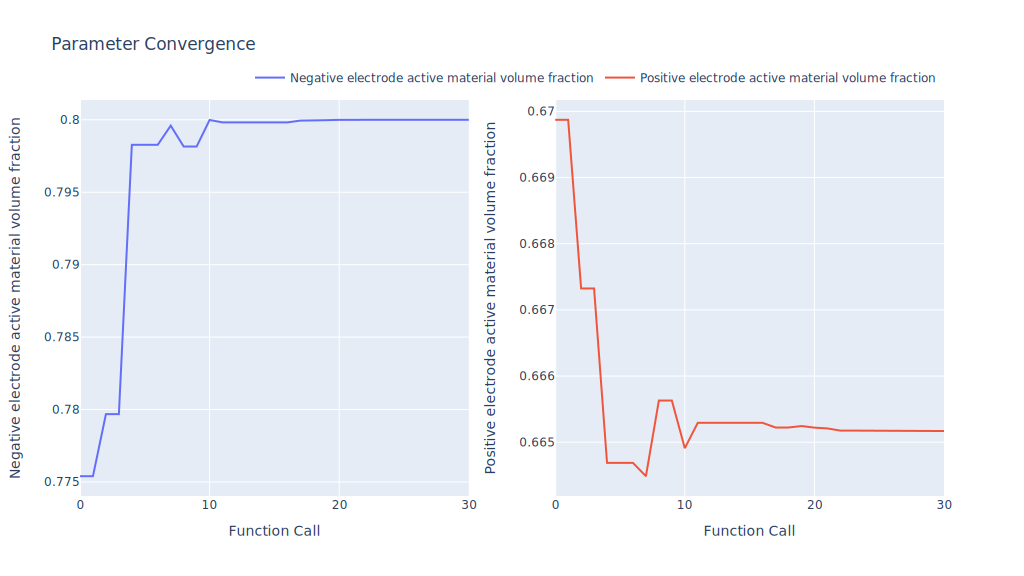

In [12]:
for optim in optims:
    pybop.plot_convergence(optim, title=optim.optimiser.name())
    pybop.plot_parameters(optim)

### Cost Landscape

Finally, we can visualise the cost landscape and the path taken by the optimiser. This should give us addition insight to whether the negative electrode volume fraction is observable or not. For an observable parameter, the cost landscape needs to have a clear minimum with respect to the parameter in question. More clearly, the parameter value has to have an effect on the cost function.

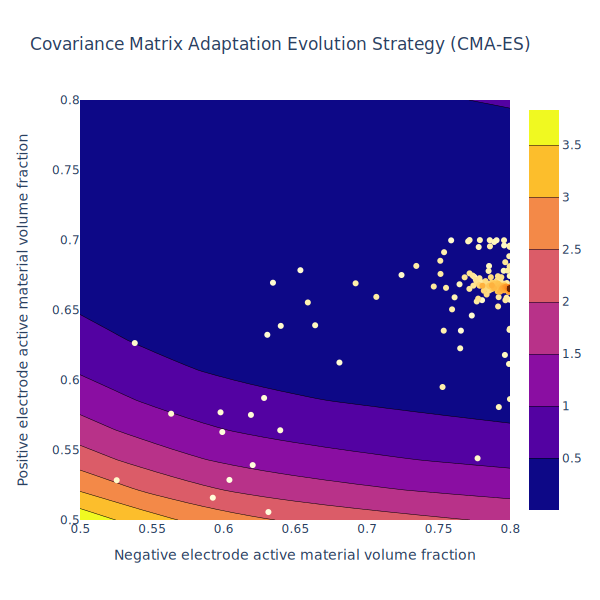

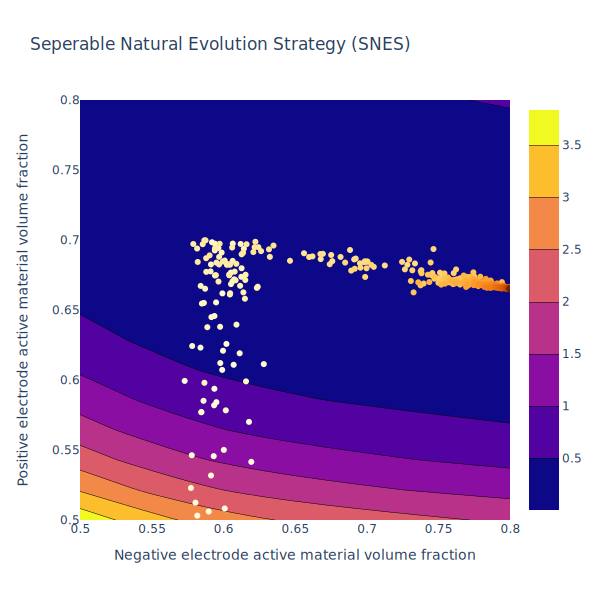

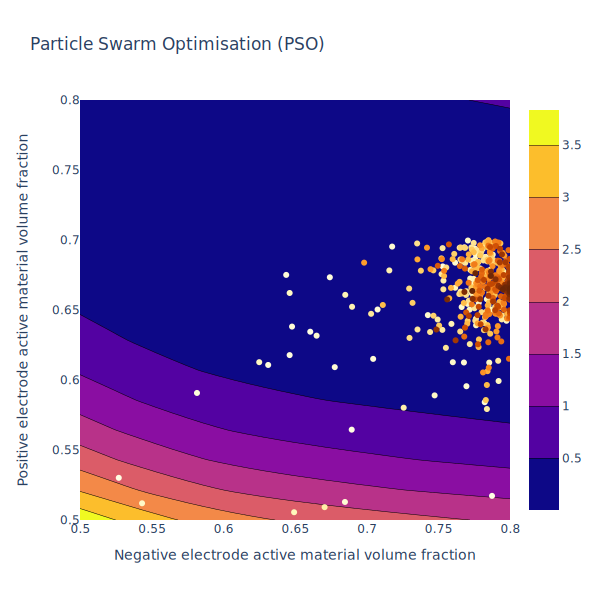

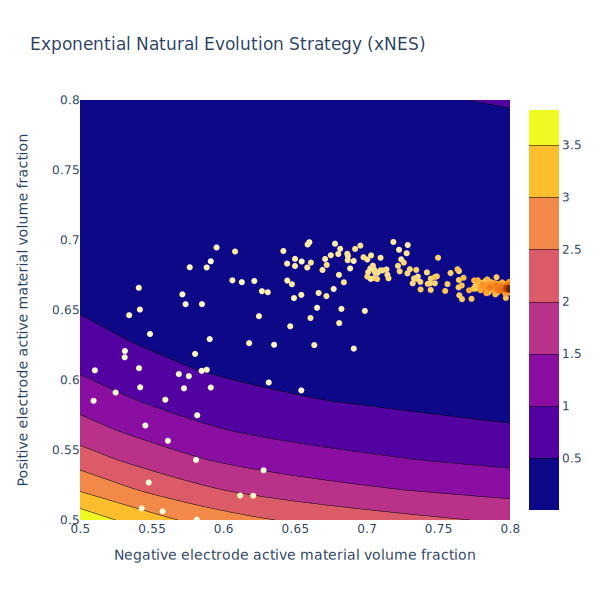

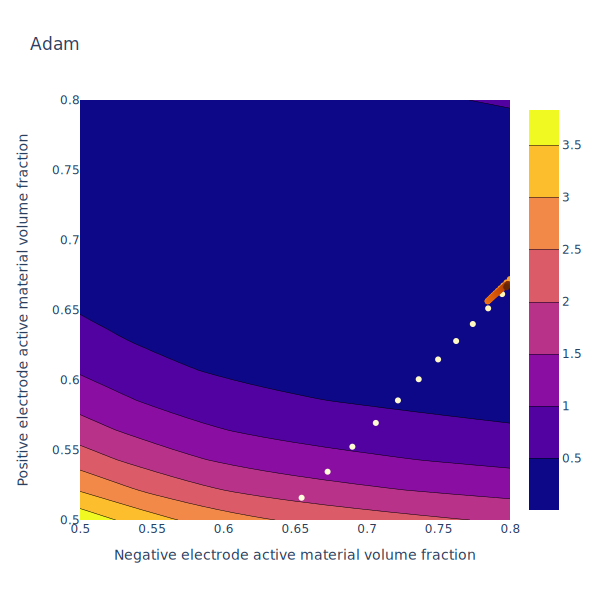

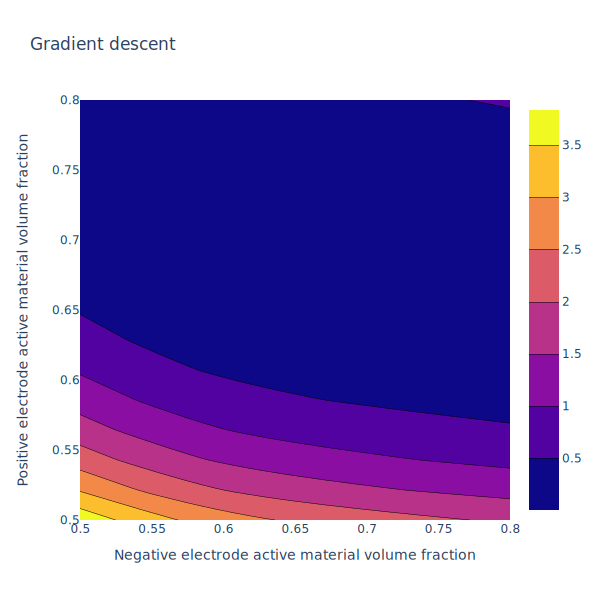

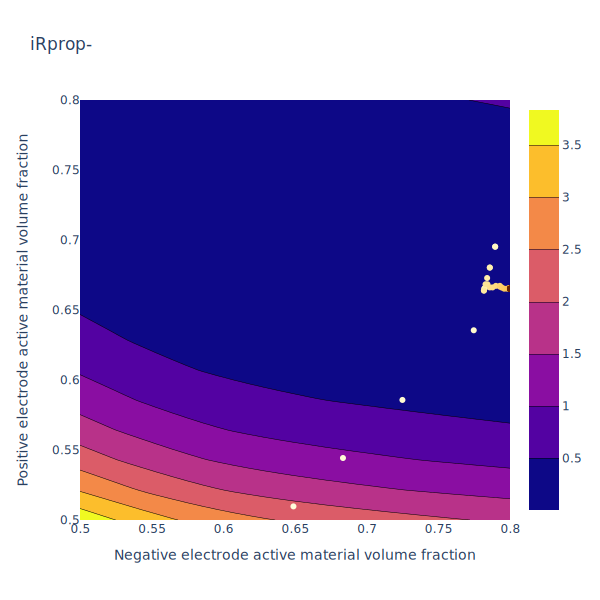

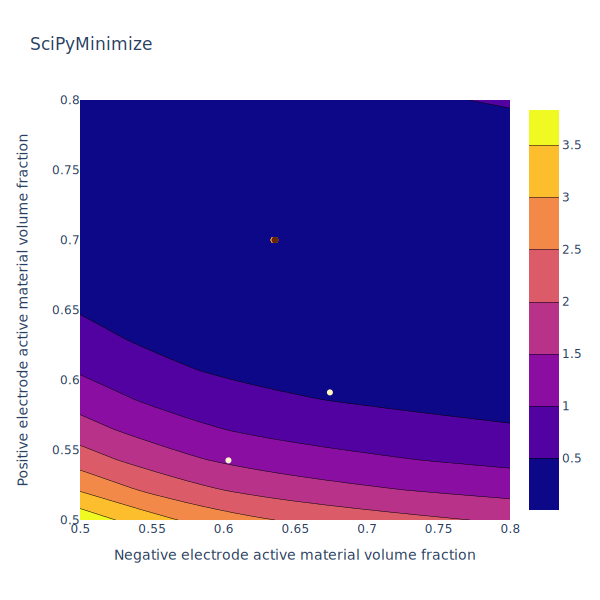

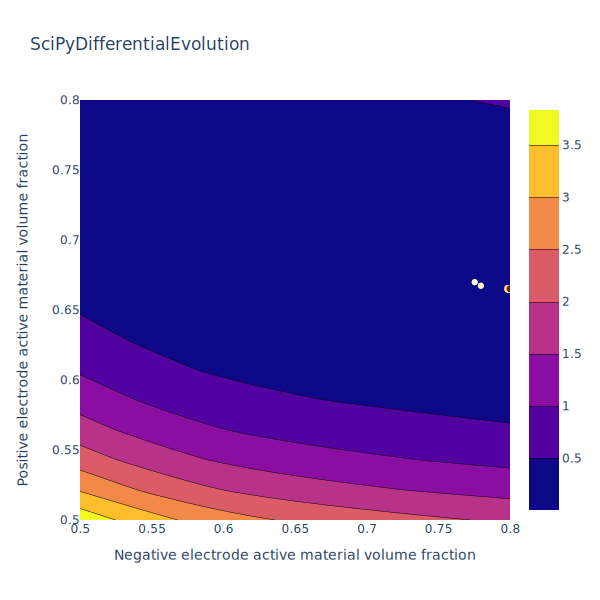

In [13]:
# Plot the cost landscape with optimisation path and updated bounds
bounds = np.array([[0.5, 0.8], [0.5, 0.8]])
for optim in optims:
    pybop.plot2d(optim, bounds=bounds, steps=15, title=optim.optimiser.name())

Given the synthetic data and corresponding system excitation, the observability of the negative electrode is quite low. As such, we would need to excite the system in a different way or observe a different signal to acquire a unique value for the `negative electrode active material fraction`.

### Conclusion

This notebook illustrates how to perform parameter estimation using PyBOP, across both gradient and non-gradient optimisers. 